<a href="https://colab.research.google.com/github/KaustubhRatna/Deep-Learning-Projects/blob/main/dc_gan_on_breakHis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
! mkdir ~/.kaggle

In [2]:
! cp /content/drive/MyDrive/kaggle_api_credentials/kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d forderation/breakhis-400x

 98% 789M/803M [00:06<00:00, 156MB/s]
100% 803M/803M [00:06<00:00, 127MB/s]


In [5]:
! unzip breakhis-400x.zip

Archive:  breakhis-400x.zip
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-001.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-003.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-004.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-005.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-007.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-011.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-015.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-019.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-025.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-027.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-028.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549CD-400-004.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549CD-400-006.png  
  inflating: BreaKHis 400X/test/beni

In [6]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt



In [7]:
dataset = keras.preprocessing.image_dataset_from_directory(
    directory = '/content/BreaKHis 400X/train/benign',
    label_mode = None,
    image_size = (64,64),
    batch_size = 32,
    shuffle=True
).map(lambda x: x/255.0)

Found 371 files belonging to 1 classes.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [14]:
discriminator = keras.Sequential(
    [
     keras.Input(shape = (64,64,3)),
     layers.Conv2D(64,kernel_size=4,strides=2,padding="same"),
     layers.LeakyReLU(0.2),
     layers.Conv2D(128,kernel_size=4,strides=2,padding="same"),
     layers.LeakyReLU(0.2),
     layers.Conv2D(128,kernel_size=4,strides=2,padding="same"),
     layers.LeakyReLU(0.2),
     layers.Flatten(),
     layers.Dropout(0.2),
     layers.Dense(1, activation='sigmoid')
    ]
)

In [13]:
print(discriminator.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 256)     12544     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128, 128, 256)     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        262208    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        65600     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 128)      

In [15]:
latent_dim = 128
generator = keras.Sequential(
    [
        layers.Input(shape = (latent_dim,)),
        layers.Dense(8*8*128),
        layers.Reshape((8,8,128)),
        layers.Conv2DTranspose(128,kernel_size=4,strides=2,padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(256,kernel_size=4,strides=2,padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(512,kernel_size=4,strides=2,padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(3,kernel_size=5,padding="same",activation="sigmoid")
    ]
)

generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 32, 32, 256)      

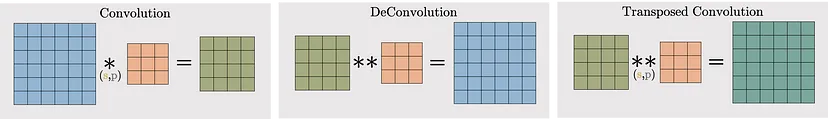

In [ ]:
opt_gen = keras.optimizers.Adam(1e-4)
opt_disc = keras.optimizers.Adam(1e-4)
loss_fn = keras.losses.BinaryCrossentropy()

for epoch in range(10000):
  for idx, real in enumerate(tqdm(dataset)):
    batch_size = real.shape[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size,latent_dim))

    fake = generator(random_latent_vectors)

    if idx % 100 ==0:
      img = keras.preprocessing.image.array_to_img(fake[0])
      img.save(f"/content/drive/MyDrive/generated_benign_images/generated_img{epoch}_{idx}_.png")
    ## Train discriminator: max ylog(D(x)) + (1-y)log(1 - D(G(z)))
    with tf.GradientTape() as disc_tape:
      loss_disc_real = loss_fn(tf.ones(batch_size,1), discriminator(real))
      loss_disc_fake = loss_fn(tf.zeros(batch_size,1), discriminator(fake))
      loss_disc = (loss_disc_fake + loss_disc_real)/2

    grads = disc_tape.gradient(loss_disc, discriminator.trainable_weights)
    opt_disc.apply_gradients(
        zip(grads, discriminator.trainable_weights)
    )

    ## Train generator minlog(1-d(g(z))) <---> max log(d(g(z)))

    with tf.GradientTape() as gen_tape:
      fake = generator(random_latent_vectors)
      output = discriminator(fake)
      loss_gen = loss_fn(tf.ones(batch_size,1),output)

    grads = gen_tape.gradient(loss_gen,generator.trainable_weights)
    opt_gen.apply_gradients(
        zip(grads,generator.trainable_weights)
    )






